# Write a function get_pretrained_model that takes as arguments the name of the architecture, the number of classes for the classification task, and whether to initialize the model using the ImageNet dataset obtained during training. 

It should have the following signature: 
```def get_pretrained_model(model_name: str, num_classes: int, pretrained: bool=True):```

Let's assume that four different model_names can be entered: alexnet, vgg11, googlenet, and resnet18. For each of them, you need to return the corresponding model from the torchvision model zoo.

In [1]:
import torch
import torch.nn as nn

from torchvision.models import alexnet
from torchvision.models import vgg11
from torchvision.models import googlenet
from torchvision.models import resnet18
from typing import Any, Callable, List, Optional, Tuple
from torch import Tensor
import torch.nn.functional as F

class BasicConv2d(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, **kwargs: Any) -> None:
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)
    
class InceptionAux(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        conv_block: Optional[Callable[..., nn.Module]] = None,
        dropout: float = 0.7,
    ) -> None:
        super().__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.conv = conv_block(in_channels, 128, kernel_size=1)

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x: Tensor) -> Tensor:
        # aux1: N x 512 x 14 x 14, aux2: N x 528 x 14 x 14
        x = F.adaptive_avg_pool2d(x, (4, 4))
        # aux1: N x 512 x 4 x 4, aux2: N x 528 x 4 x 4
        x = self.conv(x)
        # N x 128 x 4 x 4
        x = torch.flatten(x, 1)
        # N x 2048
        x = F.relu(self.fc1(x), inplace=True)
        # N x 1024
        x = self.dropout(x)
        # N x 1024
        x = self.fc2(x)
        # N x 1000 (num_classes)

        return x

def get_pretrained_model(model_name: str, num_classes: int, pretrained: bool=True):
     
    if model_name == 'alexnet':

        model = alexnet(pretrained = pretrained) 
        model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)


    elif model_name == 'vgg11':

        model = vgg11(pretrained = pretrained) 
        model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)

    elif model_name == 'googlenet':

        model = googlenet(pretrained = pretrained)
        model.fc = nn.Linear(in_features=1024, out_features=num_classes)
        model.aux1 = InceptionAux(512, num_classes) 
        model.aux2 =  InceptionAux(528, num_classes) 

    elif model_name == 'resnet18':

        model = resnet18(pretrained = pretrained) 
        model.fc = nn.Linear(model.fc.in_features, out_features=num_classes)

    else: 

        raise ValueError(f"Model {model_name} is not supported.")            

        
    return model

# Modify your best model from lesson 4 of assignment 10 and add a skip connection to it. 

Train it on CIFAR10. Compare the quality with and without the skip connection. Achieve an accuracy of 88.5% on the test sample.

To add skip-connection to the model, we need convolutional layers that accept C channels as input and return C channels. Then, in forward for a block consisting of such a convolutional layer, batch normalization, and skip-connection activation function, it will look like this:

```x = self.block(x) + x```

You need to submit code with a function that returns a model. Name this function create_advanced_skip_connection_conv_cifar. It takes no arguments and returns a model object.

Also submit predictions for the CIFAR10 test set. Use torch.save to write the tensor with the prediction results to disk. 

In [2]:
model = get_pretrained_model('googlenet', 10, pretrained=True)
model

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 182MB/s] 


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [3]:
import kagglehub
d_vladislavlantsev_cifar10_path = kagglehub.dataset_download('vladislavlantsev/cifar10')

In [4]:
import torch.nn as nn
from torch.utils.data import DataLoader
import torch
import torchvision.transforms as T
from torchvision.datasets import CIFAR10 

def get_augmentations(train: bool = True) -> T.Compose:
    
    means = (0.49139968, 0.48215841, 0.44653091)
    stds = (0.24703223, 0.24348513, 0.26158784)
    
    if train:
        train_transforms = T.Compose(
        [
            #T.Resize(size=(224, 224)),
            T.AutoAugment(T.AutoAugmentPolicy.CIFAR10),
            T.RandomHorizontalFlip(p=0.5),
            #T.RandomRotation(degrees = 30),
            T.RandomResizedCrop(size=32, scale=(0.7, 1.1)),
            T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
            T.RandomAdjustSharpness(sharpness_factor=2),
            #T.GaussianBlur(kernel_size=(3, 7), sigma=(0.2, 3)),
            #T.RandomAdjustSharpness(sharpness_factor=4),
            T.ToTensor(),
            T.Normalize(mean=means, std=stds)
        ]
        )
        
    else:
        
        train_transforms = T.Compose(
        [
            #T.Resize(size=(224, 224)),
            T.ToTensor(),
            T.Normalize(mean=means, std=stds)
        ]
        )
        
    return train_transforms

@torch.inference_mode()
def predict(model: nn.Module, loader: DataLoader, device: torch.device):
    
    model.eval()
    
    predicts =[]
    
    for x, y in loader:
        
        x, y = x.to(device), y.to(device)

        output = model(x)
        
        y_pred = torch.argmax(output, 1)
        
        predicts.append(y_pred)

    return  torch.cat(predicts)


@torch.inference_mode()
def predict_tta(model: nn.Module, loader: DataLoader, device: torch.device, iterations: int = 2):
    
    model.eval()
    
    predicts_list = []
    
    for i in range(iterations):
        
        predicts = []
        
        for x, y in loader:
                x, y = x.to(device), y.to(device)
                
                out = torch.unbind((torch.Tensor(model(x))))
                
                for i in out:
                    predicts.append(i)
                       
        predicts_tensor = torch.stack(predicts)
        predicts_list.append(predicts_tensor)
    
    predict_list_tensor = torch.stack(predicts_list)

    predict_list_tensor = torch.mean(predict_list_tensor, 0)
    
    classes_tensor = torch.argmax(predict_list_tensor, 1)

    return classes_tensor

dataset_train = CIFAR10(d_vladislavlantsev_cifar10_path, train=True, transform=get_augmentations(1))
dataset_valid = CIFAR10(d_vladislavlantsev_cifar10_path, train=False, transform=get_augmentations(0))
dataset_valid_extra = CIFAR10(d_vladislavlantsev_cifar10_path, train=False, transform=get_augmentations(1))

train_loader = DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(dataset_valid, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)
valid_loader_extra = DataLoader(dataset_valid_extra, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

In [11]:
from IPython.display import clear_output
from time import perf_counter
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

#!g1.1
from tqdm import tqdm


def train(model) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()
        
        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )
        
        #scheduler.step()
        
        if valid_accuracy >= 0.885:
            
            break

In [6]:
class SkipModel(nn.Module):
    
    def __init__(self):
        
        super().__init__()

        self.conv1 = nn.Sequential(

                nn.Conv2d(in_channels=3, 
                          out_channels=32, 
                          kernel_size=3, 
                          padding=1, 
                          padding_mode='reflect'),  # 32 x 32 x 32
                nn.BatchNorm2d(32),
                nn.ReLU(),     
        )


        self.conv2 = nn.Sequential(
            
                nn.Conv2d(in_channels=32, 
                          out_channels=64, 
                          kernel_size=3, 
                          padding=1, 
                          padding_mode='reflect'),  # 32 x 32 x 32
                nn.BatchNorm2d(64),
                nn.ReLU(),
        )


        self.conv3 = nn.Sequential(
            
                nn.Conv2d(in_channels=64, 
                          out_channels=64, 
                          kernel_size=3, 
                          padding=1, 
                          padding_mode='reflect'),  # 32 x 32 x 64
                nn.BatchNorm2d(64),
                nn.ReLU(),

        )

        self.maxpool1 = nn.Sequential(
             
                nn.MaxPool2d(2),  # 16 x 16 x 64
                nn.Dropout2d(p=0.2),

        )
        
        self.conv4 = nn.Sequential(
                nn.Conv2d(in_channels=64, 
                          out_channels=128, 
                          kernel_size=3, 
                          padding=1, 
                          padding_mode='reflect'),  # 16 x 16 x 128
                nn.BatchNorm2d(128),
                nn.ReLU(),
        )
        
        self.conv5 = nn.Sequential( 
                nn.Conv2d(in_channels=128, 
                          out_channels=256, 
                          kernel_size=3, 
                          padding=1, 
                          padding_mode='reflect'),  # 16 x 16 x 256
                nn.BatchNorm2d(256),
                nn.ReLU()

        )

        self.maxpool2 = nn.Sequential(
             
                nn.MaxPool2d(2),  # 8 x 8 x 256
                nn.Dropout2d(p=0.1),

        )

        self.conv6 = nn.Sequential( 
        
                nn.Conv2d(in_channels=256, 
                  out_channels=256, 
                  kernel_size=3, 
                  padding=1, 
                  padding_mode='reflect'),  # 8 x 8 x 256
                nn.BatchNorm2d(256),
                nn.ReLU(),
        )


        self.conv7 = nn.Sequential( 

                nn.Conv2d(in_channels=256, 
                  out_channels=512, 
                  kernel_size=3, 
                  padding=0,
                  ),  # 6 x 6 x 512
                nn.BatchNorm2d(512),
                nn.ReLU(),
        )
                
        self.conv8 = nn.Sequential( 

                nn.Conv2d(in_channels=512, 
                  out_channels=1024, 
                  kernel_size=3, 
                  padding=0,
                 ),  # 4 x 4 x 1024
                nn.BatchNorm2d(1024),
                nn.ReLU(),
        )


        self.fc = nn.Sequential(
            
                nn.Flatten(),
                nn.Linear(2 * 2 * 1024, 1024),
                nn.BatchNorm1d(1024),
                nn.Dropout(p=0.2),
                nn.ReLU(),
                nn.Linear(1024, 256),
                nn.BatchNorm1d(256),
                nn.Dropout(p=0.1),
                nn.ReLU(),
                nn.Linear(256, 10)
            
        )
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.conv2(x) 
        x = self.conv3(x) + x
        x = self.maxpool1(x)
        x = self.conv4(x) 
        x = self.conv5(x)
        x = self.maxpool2(x)
        x = self.conv6(x) + x 
        x = self.conv7(x) 
        x = self.conv8(x)
        x = self.maxpool2(x)
        
        x = self.fc(x)
        
        return x

def create_advanced_skip_connection_conv_cifar():
            
    return SkipModel()


In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

model = create_advanced_skip_connection_conv_cifar().to(device)

cuda:0


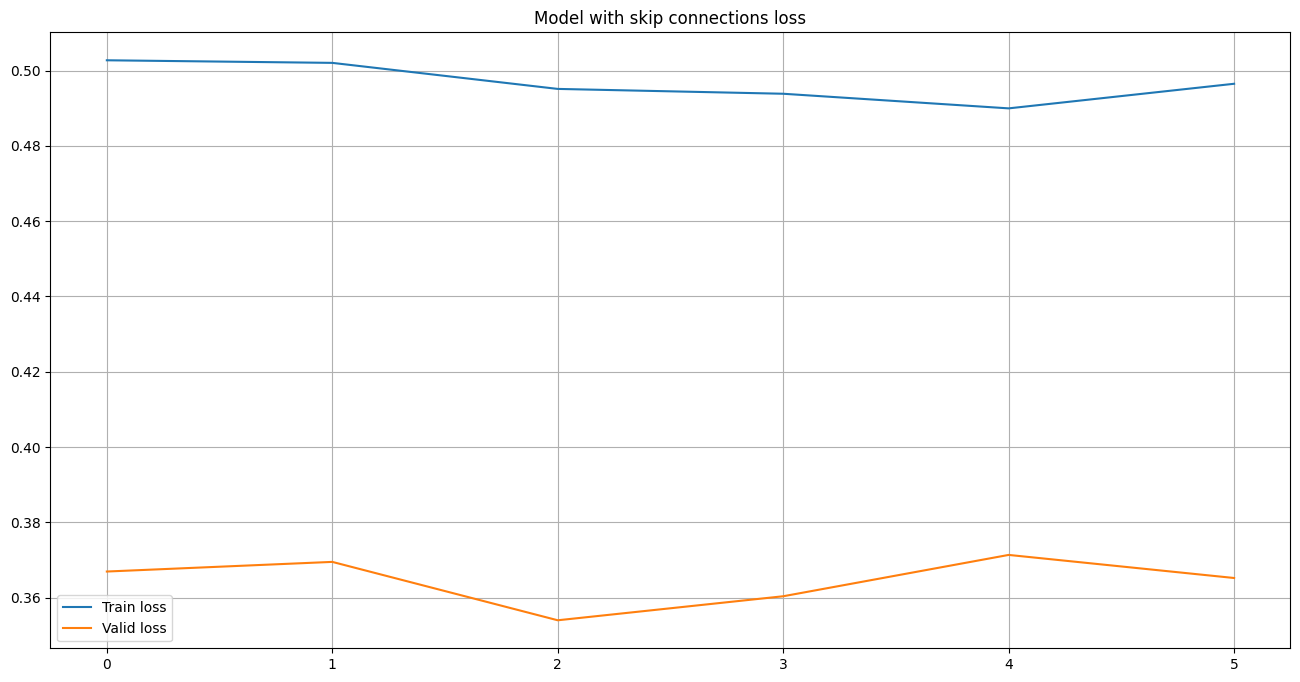

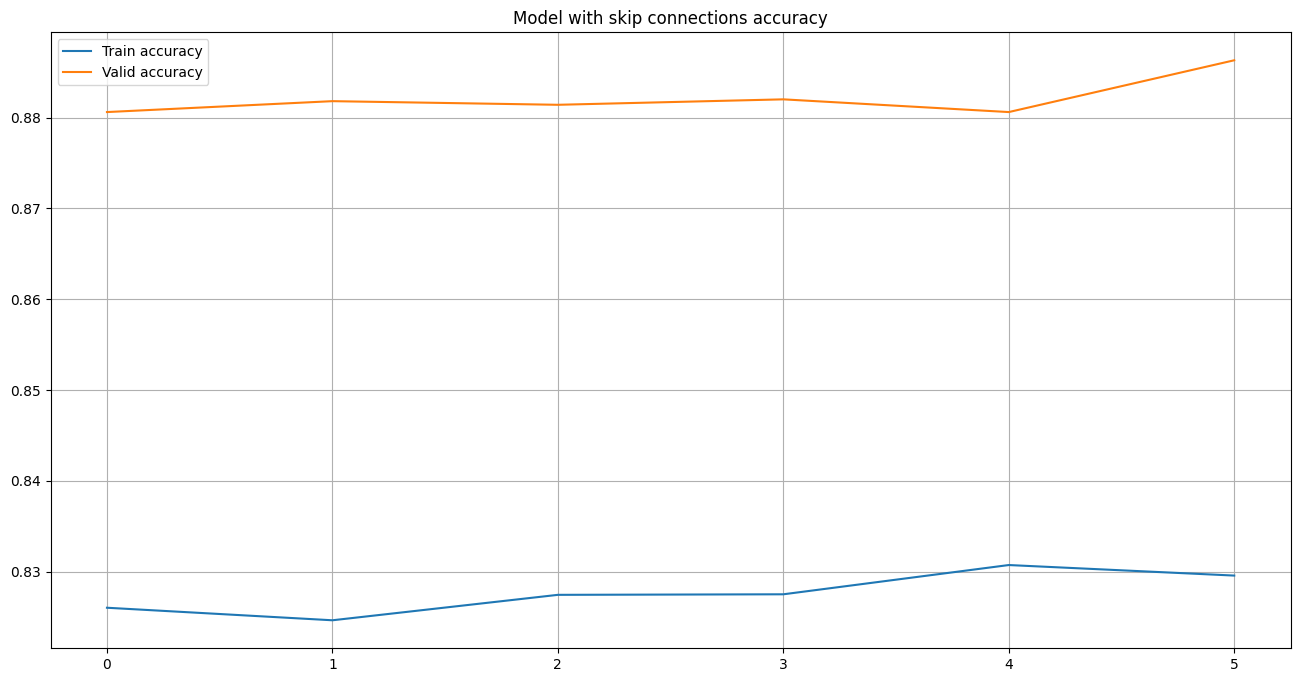

In [13]:
from torch.optim import Adam

optimizer = torch.optim.Adam(model.parameters(), lr=0.2e-3)

loss_fn = nn.CrossEntropyLoss()

whole_train_valid_cycle(model, 10, 'Model with skip connections')

In [14]:
predicts = predict(model, valid_loader, device)
torch.save(predicts, 'predicts.pt')

valid_loss, valid_accuracy = evaluate(model, valid_loader)
valid_accuracy


Evaluation: 100%|██████████| 79/79 [00:01<00:00, 44.44it/s]


0.8863